# ML Take-Home Assignment: Predicting 1D Heat Equation Solutions

## Background
The 1D heat equation is one of the simplest partial differential equations (PDEs) in computational fluid dynamics. In this assignment, you'll build a neural network to predict the temperature distribution over time, given initial conditions.

## Task Overview
1. Understand the provided code for generating training data
2. Complete the neural network architecture
3. Train the model and evaluate its performance
4. Answer some reflection questions

**Time Limit:** 2 hours

## Getting Started
First, let's import the necessary libraries and generate our training data.

In [3]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

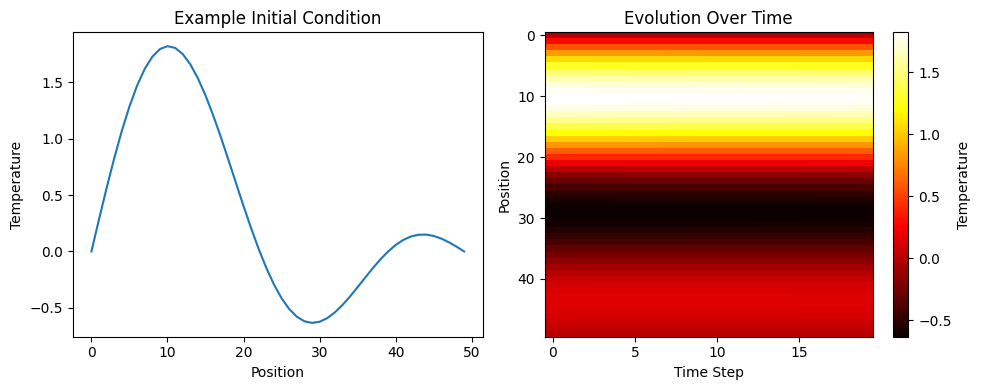

In [4]:
def generate_heat_equation_data(n_samples=1000, nx=50, nt=20, dx=0.02, dt=0.001):
    """Generate solutions for the 1D heat equation with random initial conditions."""
    # Thermal diffusivity
    alpha = 0.01
    
    # Initialize arrays
    x = np.linspace(0, 1, nx)
    solutions = np.zeros((n_samples, nt, nx))
    initial_conditions = np.zeros((n_samples, nx))
    
    for i in range(n_samples):
        # Generate random initial condition (sum of random sinusoids)
        u = np.zeros(nx)
        for k in range(1, 4):
            A = np.random.rand()
            u += A * np.sin(k * np.pi * x)
        
        initial_conditions[i] = u
        solutions[i, 0] = u
        
        # Solve heat equation using finite differences
        for t in range(1, nt):
            u[1:-1] = u[1:-1] + alpha * dt/dx**2 * (u[2:] - 2*u[1:-1] + u[:-2])
            u[0] = u[-1] = 0  # Boundary conditions
            solutions[i, t] = u
    
    return initial_conditions, solutions

# Generate data
initial_conditions, solutions = generate_heat_equation_data()

# Visualize an example
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(initial_conditions[0])
plt.title('Example Initial Condition')
plt.xlabel('Position')
plt.ylabel('Temperature')

plt.subplot(122)
plt.imshow(solutions[0].T, aspect='auto', cmap='hot')
plt.colorbar(label='Temperature')
plt.title('Evolution Over Time')
plt.xlabel('Time Step')
plt.ylabel('Position')
plt.tight_layout()
plt.show()

# Task 0: Split into Train and Test

In [7]:
# Split into train and test sets
from sklearn.model_selection import train_test_split

train_size = 0.8
X_train, X_test, y_train, y_test = train_test_split(initial_conditions, solutions, test_size=1-train_size, random_state=42)

## Task 1: Complete the Neural Network Architecture

Complete the neural network architecture below. The network should:
1. Take the initial temperature distribution (size 50) as input
2. Predict the temperature distribution at all 20 time steps (output size 20×50)
3. Use at least one hidden layer

**Hint:** Consider how to structure the network to capture both spatial and temporal dependencies. You might want to think about:
- The dimensionality of your input and output
- How to preserve spatial relationships
- Whether to use conventional dense layers or more specialized layers

In [8]:
import torch.nn.functional as F # activation functions like ReLu

In [10]:
class HeatPredictor(nn.Module):
    def __init__(self):
        super(HeatPredictor, self).__init__()
        # fully connected layers (MLP, multi-layer perceptron)

        # input layer
        self.fc1 = nn.Linear(50, 128)
        # hidden layers 
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 1000)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) 

        return x.view(-1, 20, 50) 

## Task 2: Training Loop

Complete the training loop below. Make sure to:
1. Define appropriate loss function and optimizer
2. Reshape the predictions and targets as needed
3. Track and plot the training loss

Epoch 5 of 100, Loss: 0.39731184
Epoch 10 of 100, Loss: 0.19208536
Epoch 15 of 100, Loss: 0.10552085
Epoch 20 of 100, Loss: 0.05302015
Epoch 25 of 100, Loss: 0.04582044
Epoch 30 of 100, Loss: 0.02851119
Epoch 35 of 100, Loss: 0.01662990
Epoch 40 of 100, Loss: 0.00843794
Epoch 45 of 100, Loss: 0.00663603
Epoch 50 of 100, Loss: 0.00351113
Epoch 55 of 100, Loss: 0.00218118
Epoch 60 of 100, Loss: 0.00165559
Epoch 65 of 100, Loss: 0.00119207
Epoch 70 of 100, Loss: 0.00086944
Epoch 75 of 100, Loss: 0.00070791
Epoch 80 of 100, Loss: 0.00057602
Epoch 85 of 100, Loss: 0.00046975
Epoch 90 of 100, Loss: 0.00039638
Epoch 95 of 100, Loss: 0.00033951
Epoch 100 of 100, Loss: 0.00029709


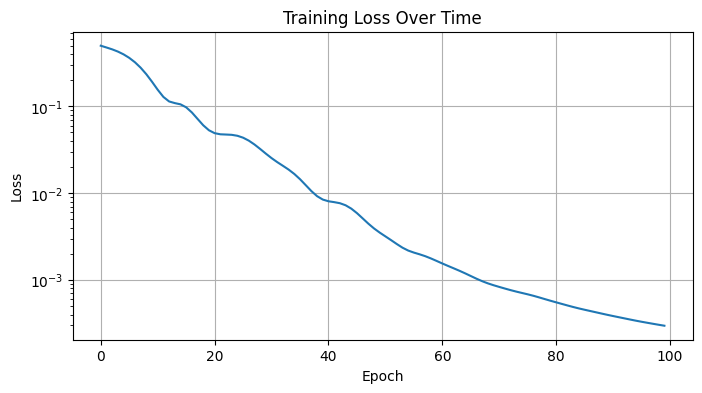

In [20]:
def train_model(model, X_train, y_train, epochs=100):
    import torch.optim as optim
   
    # step 1
    loss_fcn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # step 2
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)

    losses = []

    # step 3
    for epoch in range(epochs):
        optimizer.zero_grad()  # zero gradients from previous step

        # fwd pass
        predictions = model(X_train)  # Output shape: (batch, 20, 50)
        # loss computation
        loss = loss_fcn(predictions, y_train)
        # bkwd pass: compute gradients
        loss.backward()
        # updating weights
        optimizer.step()
    
        losses.append(loss.item())

        # progress
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1} of {epochs}, Loss: {loss.item():.8f}")

    return losses

# Initialize and train your model
model = HeatPredictor()
losses = train_model(model, X_train, y_train)

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(True)
plt.show()

## Task 3: Evaluation

Complete the following code to evaluate your model's performance:
1. Plot predicted vs. actual temperature distributions for a test case
2. Calculate and report the mean squared error on the test set

Test MSE: 0.000324


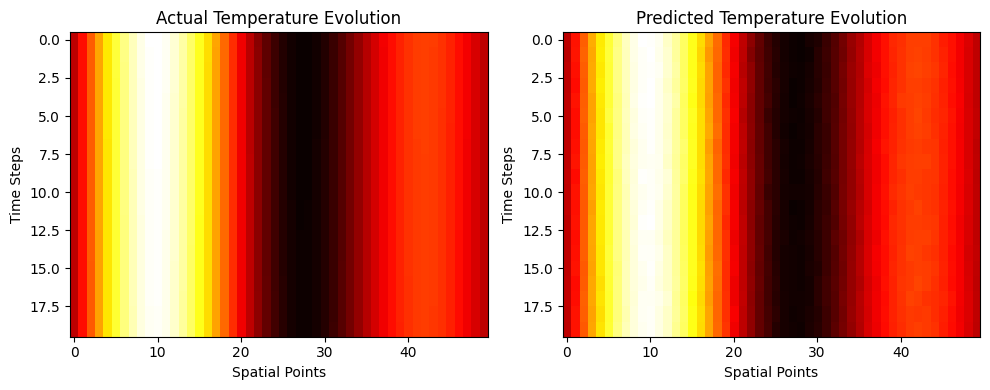

In [22]:
from sklearn.metrics import mean_squared_error

def evaluate_model(model, X_test, y_test):

    model.eval()
      
    # numpy arrays -> torchs
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    # step 1: making predictions w/o gradients
    with torch.no_grad():
        predictions = model(X_test)  # Output shape: (batch, 20, 50)
    
    # step 2: computing MSE
    test_mse = mean_squared_error(y_test.numpy().flatten(), predictions.numpy().flatten())
    print(f"Test MSE: {test_mse:.6f}")

    # step 3: visualization: predictions vs actual
    sample_idx = np.random.randint(0, X_test.shape[0])  # random test example
    true_temps = y_test[sample_idx].numpy()  # true temperature evolution
    pred_temps = predictions[sample_idx].numpy()  # predicted temperature evolution

    # heatmaps for true vs. predicted temperatures
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    axes[0].imshow(true_temps, aspect='auto', cmap='hot')
    axes[0].set_title("Actual Temperature Evolution")
    axes[0].set_xlabel("Spatial Points")
    axes[0].set_ylabel("Time Steps")

    axes[1].imshow(pred_temps, aspect='auto', cmap='hot')
    axes[1].set_title("Predicted Temperature Evolution")
    axes[1].set_xlabel("Spatial Points")
    axes[1].set_ylabel("Time Steps")

    plt.tight_layout()
    plt.show()

# Evaluate your model
evaluate_model(model, X_test, y_test)

## Reflection Questions

Please answer the following questions briefly (2-3 sentences each):

1. How did you choose your neural network architecture? What other architectures did you consider?

2. What are the limitations of your current approach? How might you improve it if you had more time?

3. How might this simplified 1D problem relate to more complex CFD simulations? What additional challenges would you expect when scaling to 2D or 3D?

Your answers:
1. [Your answer here]
2. [Your answer here]
3. [Your answer here]